In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [1]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('../data/clean_data.csv', index_col='Municipality')
df.drop('missing_count', axis=1, inplace=True)

<AxesSubplot:>

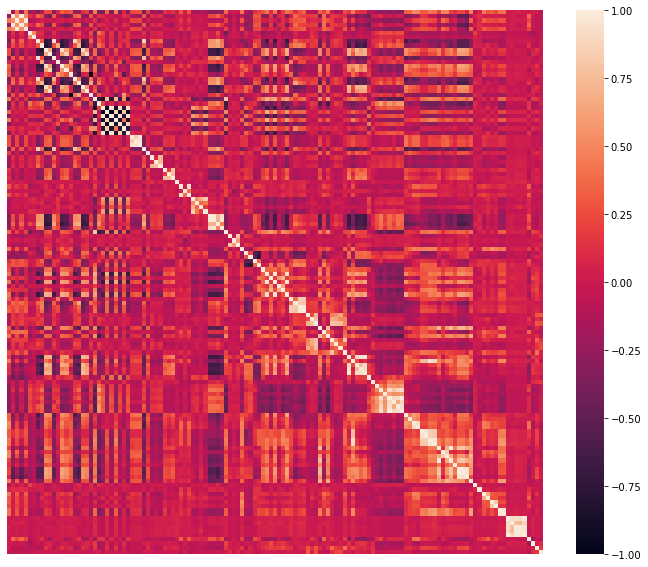

In [3]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr, xticklabels=False, yticklabels=False, ax=ax)

In [4]:
# Split label from data
labels = df.filter(like='catalan').columns
df.loc[:, df.columns.isin(labels)].describe()

,culture_knowledge_of_catalan_speak
count,919.000000
mean,0.797635
std,0.088523
min,0.267603
25%,0.748330
50%,0.813527
75%,0.859326
max,1.000000


In [5]:
df = df.loc[:, ~df.columns.isin(labels)]

In [6]:
num_features = df.select_dtypes(include='number').columns
cat_features = df.select_dtypes(exclude='number').columns

In [7]:
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
    ],
    verbose_feature_names_out=False
)

In [8]:
preprocessed_data = preprocessor.fit_transform(df)
cols = preprocessor.get_feature_names_out()

In [9]:
pca = PCA()
pca_data = pca.fit_transform(preprocessed_data)
exp_var = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var)

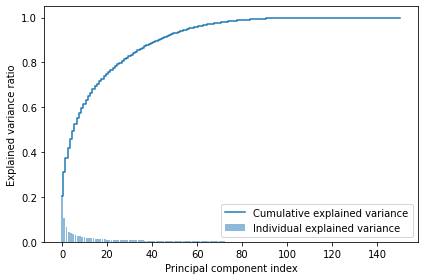

In [10]:
plt.bar(range(0,len(exp_var)), exp_var, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Cumulative explained variance: 0.74


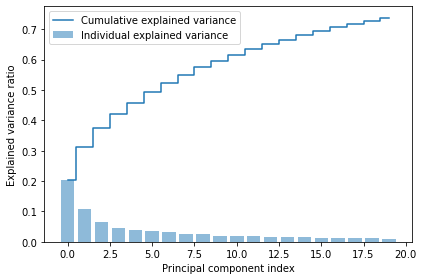

In [11]:
def cumulative_exp_car(components=20):
    exp_var_filtered = exp_var[0:components]
    cum_sum_filtered = cum_sum_eigenvalues[0:components]
    print('Cumulative explained variance:', round(cum_sum_filtered[components-1], 2))
    plt.bar(range(0,len(exp_var_filtered)), exp_var_filtered, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_filtered)), cum_sum_filtered, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
cumulative_exp_car()

In [12]:
loadings = pca.components_
num_pc = 30 #pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = cols
loadings_df = loadings_df.set_index('variable')
loadings_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
variable,,,,,,,,,,,,,,,,,,,,,
territory__altitude,0.099751,0.088358,0.085707,0.078746,-0.038142,0.013934,-0.029846,0.104234,-0.119729,-0.125276,...,-0.008363,-0.013965,0.140188,-0.056031,0.091202,0.043914,0.146312,0.045587,-0.081228,-0.047807
territory__longitude,-0.072997,0.116286,0.019215,-0.049116,-0.162548,0.086364,-0.076589,-0.058741,0.164866,-0.062469,...,-0.093638,0.012410,-0.105530,-0.067411,-0.064528,0.027405,-0.073674,0.008132,-0.000680,-0.005613
territory__latitude,0.025035,0.119208,0.126072,-0.063190,-0.171939,0.091551,-0.105354,0.124502,0.023670,-0.130856,...,0.023378,-0.017507,0.053348,-0.021576,0.016474,0.076323,-0.039898,-0.055129,-0.074103,-0.009774
territory__geographic_indicators_utm_coordinates_x_utm_coordinates_x,-0.072403,0.117388,0.020466,-0.048959,-0.163571,0.086957,-0.077404,-0.055644,0.163751,-0.063368,...,-0.093062,0.012031,-0.104155,-0.067755,-0.063743,0.028432,-0.073395,0.007627,-0.002054,-0.005632
territory__geographic_indicators_utm_coordinates_y_utm_coordinates_y,0.026868,0.117582,0.127466,-0.063687,-0.170522,0.090703,-0.104948,0.126276,0.020819,-0.130755,...,0.026187,-0.018056,0.055567,-0.019822,0.017578,0.076544,-0.039475,-0.056534,-0.074166,-0.009563


In [13]:
def top_dimensions(df, n=10):
    import pandas as pd
    
    top_df = pd.DataFrame()
    for col in df.columns:
        vars_ix = df.loc[:, col].apply(lambda x: abs(x)).sort_values(ascending=False)[0:n].index
        new_col = df.loc[vars_ix, col].sort_values(ascending=False).reset_index().apply(lambda x : '{} ({})'.format(x[0],x[1]), axis=1)
        top_df = pd.concat([top_df, pd.DataFrame(new_col, columns=[col])], axis=1)
        
    return top_df

In [14]:
pd.set_option('display.max_colwidth', 100)
top_dimensions(loadings_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,elections_elections_to_the_european_parliament_electors (0.16492604210341522),labour_affiliations_to_social_security_according_to_contributor_s_residence_affiliations_to_soci...,population_population_by_place_of_birth_abroad (0.19215505105640932),labour_registered_unemployment_by_sectors_by_sectors_services (0.24587976886713753),economic_sectors_fleet_of_vehicles_total (0.2296373135895889),economic_sectors_fleet_of_vehicles_total (0.3947150412365381),labour_affiliations_to_general_system_according_to_location_of_affilation_by_sectors_total (0.35...,economic_sectors_used_agricultural_area_total (0.2434260711470681),main_aggregates_personal_resulting_quota_from_self_payment_by_declarer (0.21414460714049408),population_population_resident_abroad_on_1_january_women (0.21103679221748473),...,economic_sectors_used_agricultural_area_permanent_pasture (0.24696462386981938),economic_sectors_housing_construction_housing_starts (0.4470313229793132),quality_of_life_type_of_dwellings_vacant (0.20850056531000663),economic_sectors_tourist_accommodation_campsite_places (0.2625219847880008),population_marriages_marriages_total (0.2979183165628479),culture_libraries_others (0.27954640889265225),environment_municipal_waste_selective_collection (0.39209607021248005),population_population_by_sex_total (0.21798393636784366),environment_industrial_waste_industrial_waste (0.34526538182388555),economic_sectors_housing_construction_state_subsidised_housing_starts (0.6854700270805183)
1,elections_elections_to_the_congress_of_deputies_electors (0.15888734650604433),labour_contributors_to_social_security_according_to_contributors_s_residence_contributors_to_soc...,main_aggregates_urban_property_tax_number_of_receipts (0.1902115194903328),labour_registered_unemployment_by_sex_registered_unemployment_total (0.22612733130949536),economic_sectors_fleet_of_vehicles_estate_cars (0.22693268433598124),economic_sectors_fleet_of_vehicles_estate_cars (0.3925138556726612),labour_affiliations_to_gen_system_according_to_location_of_affilation_s_general_system_according...,economic_sectors_used_agricultural_area_permanent_pasture (0.22975760886405378),main_aggregates_personal_taxable_base_by_declarer (0.20998403857988113),population_population_resident_abroad_on_1_january_total (0.2056112067902132),...,population_births_by_sex_girls (0.21805082326986527),economic_sectors_land_ownership_without_land (0.23408937494488605),culture_libraries_others (0.17102143395399888),main_aggregates_urban_property_tax_taxable_base_by_receipt (0.21798979677864783),population_study_reasons_students_who_study_in_the_same_municipality (0.28734664079423294),population_internal_migrations_destination_origin_balances_balance_with_catalonia (0.24669310432...,population_births_by_sex_boys (0.2570380589935969),culture_libraries_others (0.1904907085926134),environment_municipal_waste_selective_collection (0.2736745204377436),population_births_by_sex_girls (0.24482714275872905)
2,population_men_population_from_65_to_84_years (0.155552912920326),labour_contributors_to_social_security_according_to_contributors_s_residence_contributors_to_soc...,population_population_by_nationality_foreign (0.18309762108598465),labour_registered_unemployment_by_sectors_registered_unemployment_total (0.22611691804292045),economic_sectors_fleet_of_vehicles_others (0.22618241707648493),economic_sectors_fleet_of_vehicles_industrial_vehicles (0.3823845748178627),labour_affiliations_to_gen_system_according_to_location_of_affilation_s_general_system_according...,economic_sectors_livestock_ownership_with_livestock (0.22409921544197675),main_aggregates_urban_property_tax_taxable_base_by_receipt (0.2054199970138174),population_population_resident_abroad_on_1_january_men (0.18243154015583385),...,population_men_population_from_85_years_and_over (0.17185258208651866),labour_affiliations_to_gen_system_according_to_location_of_affilatio

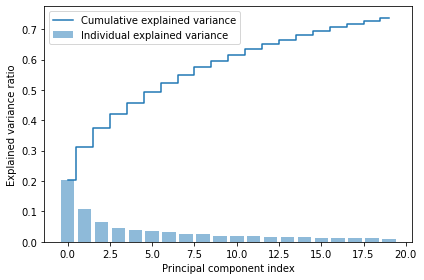

In [15]:
pca = PCA(20)
pca_data = pca.fit_transform(preprocessed_data)
exp_var = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var)

plt.bar(range(0,len(exp_var)), exp_var, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Clustering

### KMeans

In [18]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

index= pd.MultiIndex.from_arrays([['kmeans'], [3]], names=('model', 'K'))
results_df = pd.DataFrame(index=index, columns=['CH score', 'Silhouette score', 'DB score'])

def compute_clustering_and_plot(K, data, results, method='kmeans'):
    # Train the model
    if method == 'kmeans':
        cluster = KMeans(n_clusters=K, max_iter=100)
        cluster.fit(data);
    elif method == 'spectral':
        cluster = SpectralClustering(n_clusters=K)
        cluster.fit(data);
    else:
        return 'Method not recognized'
    
    data['cluster_labels'] = cluster.labels_
    
    # Plot results
    # sns.scatterplot(x='X', 
    #            y='Y',
    #            hue='cluster_labels', 
    #            data=data);
    # plt.plot(cluster.cluster_centers_[:,0], 
    #      cluster.cluster_centers_[:,1], 
    #      'bo', markersize=12,alpha=0.7);
    # plt.xlim(plt.ylim());
    
    # plt.title('K Means predictions with K={}'.format(K));
    # plt.show();
    
    # Compute metrics
    CH = calinski_harabasz_score(data, cluster.labels_)
    S = silhouette_score(data, cluster.labels_ )
    DB = davies_bouldin_score(data, cluster.labels_ )
    
    results.loc[(method, K),:] = [CH,S,DB]
    return results

In [35]:
num_pc = pca.n_components_
red_df = pd.DataFrame(data=pca_data, index=df.index, columns=["PC"+str(i) for i in list(range(1, num_pc+1))])
red_df.to_csv('../data/model_data.csv')

In [242]:
for k in range(2,8,2):
    results = compute_clustering_and_plot(k, red_df, results_df, method='spectral')
results_df

/home/enric/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/enric/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/enric/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:369: UserWarning: Exited at iteration 1376 with accuracies 
[3.66149959e-13 5.18237699e-06 1.66781678e-05 1.01870874e-05
 9.92950356e-06]
not reaching the requested tolerance 1e-05.
  _, diffusion_map = lobpcg(
/home/enric/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:366: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  est = KMeans(
/home/enric/miniconda3/envs/ml/lib/pyth

CH score Silhouette score  DB score
model    K                                     
kmeans   3       NaN              NaN       NaN
spectral 2   7.98024         0.556481  0.324677
         4  7.793577         0.535398  0.330729
         6  7.744244         0.515458    1.1636